In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

plt.rc('font', size=30)

In [2]:
datasets = ['cub', 'mimic', 'mnist', 'vdem']

In [3]:
sota_files = glob.glob('./results/**/*summary.csv', recursive = True)
sota_files

['./results\\cub_summary.csv',
 './results\\mimic_summary.csv',
 './results\\mnist_summary.csv',
 './results\\vdem_summary.csv']

In [4]:
lens_files = glob.glob('./results/**/results*.csv', recursive = True)
lens_files

['./results\\CUB\\explainer\\results_aware_cub.csv',
 './results\\mimic-ii\\explainer\\results_aware_mimic.csv',
 './results\\MNIST\\explainer\\results_aware_mnist.csv',
 './results\\vdem\\explainer\\results_aware_vdem.csv']

In [5]:
dataset = datasets[-1]
sota_file = [f for f in sota_files if dataset in f][0]
sota_df = pd.read_csv(sota_file, index_col=0)

In [6]:
lens_file = [f for f in lens_files if dataset in f][0]
lens_df = pd.read_csv(lens_file, index_col=0)
lens_df.mean()

explanation_accuracy        0.898838
explanation_fidelity        0.909010
explanation_complexity      3.100000
model_accuracy              0.945052
extraction_time            59.901306
extracted_concepts         11.500000
explanation_consistency     0.462500
dtype: float64

In [7]:
df = sota_df[['explanation_complexity_mean', 'explanation_accuracy_mean']]
new_row = {'explanation_complexity_mean': lens_df.mean()['explanation_complexity'], 
           'explanation_accuracy_mean': 100*lens_df.mean()['explanation_accuracy']}
df = df.append(new_row, ignore_index=True)
df.columns = ['Complexity', 'Error (%)']
df.index = ['Tree', 'BRL', 'Psi network', 'Entropy-based network']
df['Error (%)'] = 100 - df['Error (%)']
df

,Complexity,Error (%)
Tree,30.2,14.550285
BRL,145.7,8.786846
Psi network,5.4,32.923688
Entropy-based network,3.1,10.116182


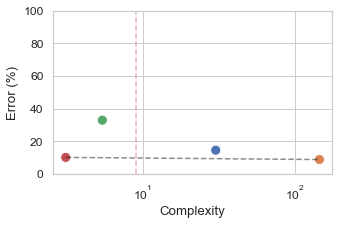

In [8]:
def is_pareto_efficient_dumb(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_efficient[i] = np.all(np.any(costs[:i]>c, axis=1)) and np.all(np.any(costs[i+1:]>c, axis=1))
    return is_efficient

#%%

is_efficient = is_pareto_efficient_dumb(df[['Complexity', 'Error (%)']].values)
is_efficient

#%%

is_efficient_sorted_idx = df['Complexity'][is_efficient].argsort().values
is_efficient_sorted_idx

#%%

is_efficient_sorted_x = df['Complexity'][is_efficient][is_efficient_sorted_idx].values
is_efficient_sorted_x

#%%

is_efficient_sorted_y = df['Error (%)'][is_efficient][is_efficient_sorted_idx].values
is_efficient_sorted_y

#%%

sns.set(font_scale=1.1)
sns.set_style("whitegrid")
plt.figure(figsize=[5, 3])
plt.plot([9, 9], [0, 100], c='r', linestyle='--', alpha=0.4)
# plt.text(3, 26, 'Max complexity ~9', {'color':  'r', 'backgroundcolor': 'w', 
#                                        'bbox': {'fc': 'w', 'ec': 'r', 'ls': '--'}})
sns.lineplot(x=is_efficient_sorted_x, y=is_efficient_sorted_y, color='k', linestyle='--', alpha=0.5)
sns.scatterplot(data=df, x='Complexity', y='Error (%)', hue=df.index, s=100, legend=False)
plt.xscale('log')
plt.ylim([0, 100])
plt.show()

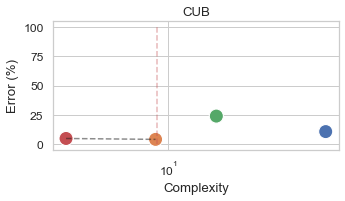

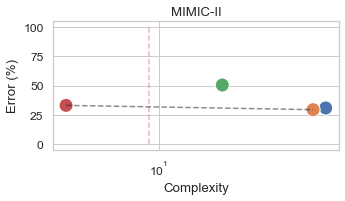

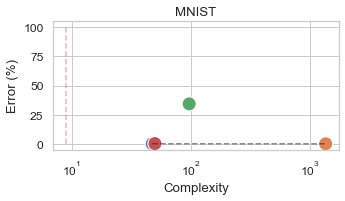

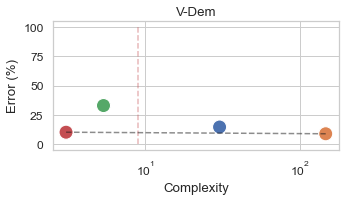

In [9]:
titles = ['CUB', 'MIMIC-II', 'MNIST', 'V-Dem']
for dataset, title in zip(datasets, titles):
    sota_file = [f for f in sota_files if dataset in f][0]
    sota_df = pd.read_csv(sota_file, index_col=0)
    lens_file = [f for f in lens_files if dataset in f][0]
    lens_df = pd.read_csv(lens_file, index_col=0)
    df = sota_df[['explanation_complexity_mean', 'explanation_accuracy_mean']]
    new_row = {'explanation_complexity_mean': lens_df.mean()['explanation_complexity'], 
               'explanation_accuracy_mean': 100*lens_df.mean()['explanation_accuracy']}
    df = df.append(new_row, ignore_index=True)
    df.columns = ['Complexity', 'Error (%)']
    df.index = ['Tree', 'BRL', '$\psi$ network', 'Entropy-based network']
    df['Error (%)'] = 100 - df['Error (%)']
    
    is_efficient = is_pareto_efficient_dumb(df[['Complexity', 'Error (%)']].values)
    is_efficient_sorted_idx = df['Complexity'][is_efficient].argsort().values
    is_efficient_sorted_x = df['Complexity'][is_efficient][is_efficient_sorted_idx].values
    is_efficient_sorted_y = df['Error (%)'][is_efficient][is_efficient_sorted_idx].values
    
    plt.figure(figsize=[5, 3])
    plt.title(title)
    plt.plot([9, 9], [0, 100], c='r', linestyle='--', alpha=0.4)
#     plt.text(3, 42, 'Max complexity ~9', {'color':  'r', 'backgroundcolor': 'w', 
#                                            'bbox': {'fc': 'w', 'ec': 'r', 'ls': '--'}})
    sns.lineplot(x=is_efficient_sorted_x, y=is_efficient_sorted_y, color='k', linestyle='--', alpha=0.5)
    sns.scatterplot(data=df, x='Complexity', y='Error (%)', hue=df.index, s=200, legend=False)
    plt.xscale('log')
    plt.ylim([-5, 105])
    plt.tight_layout()
    plt.savefig(f"./results/{title}_pareto.png")
    plt.savefig(f"./results/{title}_pareto.pdf")
    plt.show()

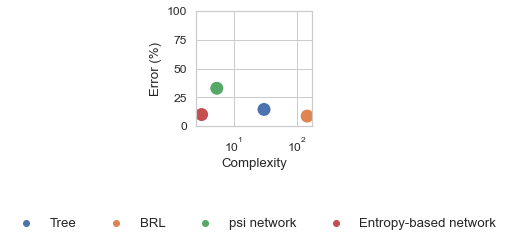

In [10]:
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

df['Method'] = ['Tree', 'BRL', '$\psi$ network', 'Entropy-based network']
df['Method'] = ['Tree', 'BRL', 'psi network', 'Entropy-based network']
plt.figure(figsize=[5, 8])
sns.scatterplot(data=df, x='Complexity', y='Error (%)', hue='Method', s=200)
plt.xscale('log')
plt.ylim([0, 100])
plt.legend(loc='lower center', fontsize='medium', ncol=5, frameon=False, 
           bbox_to_anchor=(0.5, -1),fancybox=False, shadow=False)
plt.tight_layout()
plt.savefig('./results/legend.png', bbox_inches=mpl.transforms.Bbox([[-0.8, 4.7], [5.9, 4.9]]))
plt.savefig('./results/legend.pdf', bbox_inches=mpl.transforms.Bbox([[-0.8, 4.7], [5.9, 4.9]]))
plt.show()